In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

In [2]:
countries_iso = ['BEL', 'CHE', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'ITA', 'NLD', 'NOR', 'PRT', 'SWE']
countries_names = ['Belgium', 'Switzerland', 'Denmark', 'Spain', 'Finland', 'France', 'United Kingdom', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Sweden']

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "nato_dataset.csv")
print("NATO dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

NATO dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/nato_dataset.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)

In [5]:
iso_col, time_col = "iso", "year"

df[iso_col]  = df[iso_col].astype(str).str.upper().str.strip()
df[time_col] = pd.to_numeric(df[time_col], errors="coerce").astype("Int64")
df = df.dropna(subset=[iso_col, time_col]).copy()
df[time_col] = df[time_col].astype(int)

df = df.sort_values([iso_col, time_col]).drop_duplicates([iso_col, time_col])

In [6]:
vars_endog = ["mil_delta","log_gov_pc","log_rgdp_pc","tbill","log_tfp","def_gdp","debt_gdp"]

In [7]:
data = df[[iso_col, time_col] + vars_endog].dropna().copy()

# pooled z-score like ADS
mu = data[vars_endog].mean()
sd = data[vars_endog].std(ddof=0)
data_z = data.copy()
data_z[vars_endog] = (data_z[vars_endog] - mu) / sd

In [8]:
p = 15

In [9]:
def build_panel_XY_and_country_index(dfz, y_vars, p, iso_col="iso", time_col="year"):
    Ys, Xs, cs = [], [], []
    iso_list = []

    for iso, g in dfz.sort_values([iso_col, time_col]).groupby(iso_col):
        Y = g[y_vars].to_numpy()
        T = Y.shape[0]
        if T <= p:
            continue

        Yt = Y[p:]  # (T-p, K)
        Xl = np.stack([Y[p-(i+1):-(i+1)] for i in range(p)], axis=1)  # (T-p, p, K)

        Ys.append(Yt)
        Xs.append(Xl)
        cs.append(np.full((T-p,), len(iso_list), dtype=int))
        iso_list.append(iso)

    return np.concatenate(Ys, 0), np.concatenate(Xs, 0), np.concatenate(cs, 0), iso_list

Y_target, Xlags, c_idx, countries = build_panel_XY_and_country_index(data_z, vars_endog, p=p)

N, K = Y_target.shape
C = len(countries)
print("N,K,C,p:", N, K, C, p, "| Xlags:", Xlags.shape)

N,K,C,p: 617 7 12 15 | Xlags: (617, 15, 7)


In [10]:
lambda_ = 0.08      # or 0.10
theta   = 0.10      # or 0.15
alpha   = 2.0       # 1.5–2.0 is common

lag_idx = np.arange(1, p+1)
lag_scale = lambda_ / (lag_idx ** alpha)  # (p,)

own = np.eye(K)
cross = 1 - own
var_scale = own + theta * cross

sigma_A = lag_scale[:, None, None] * var_scale[None, :, :]  # (p,K,K)

mu_A = np.zeros((p, K, K))
mu_A[0, np.arange(K), np.arange(K)] = 0.7   # prior mean for lag-1 own-lags

In [11]:
coords = {
    "obs": np.arange(N),
    "vars": vars_endog,
    "cross_vars": vars_endog,
    "lags": np.arange(1, p+1),
    "country": countries,
}

with pm.Model(coords=coords) as nato_panel_pooled:
    X = pm.Data("Xlags", Xlags, dims=("obs","lags","cross_vars"))
    Y = pm.Data("Y_target", Y_target, dims=("obs","vars"))
    c = pm.Data("c_idx", c_idx, dims=("obs",))

    # country intercepts (fixed effects), non-centered
    alpha_mu  = pm.Normal("alpha_mu", 0.0, 0.3, dims=("vars",))
    alpha_sd  = pm.HalfNormal("alpha_sd", 0.3, dims=("vars",))
    alpha_raw = pm.Normal("alpha_raw", 0.0, 1.0, dims=("country","vars"))
    alpha_raw_ctr = pm.Deterministic("alpha_raw_ctr", alpha_raw - alpha_raw.mean(axis=0))
    alpha = pm.Deterministic("alpha", alpha_mu + alpha_sd * alpha_raw_ctr)

    # pooled lag coefficients (same for every country)
    lag_coefs = pm.Normal(
        "lag_coefs",
        mu=pt.constant(mu_A.astype("float32")),
        sigma=pt.constant(sigma_A.astype("float32")),
        dims=("lags","vars","cross_vars"),
    )

    noise = pm.HalfNormal("noise", 0.5, dims=("vars",))  # z-data: 0.5 is a good start
    
    mean = alpha[c] + pt.einsum("nlk,ljk->nj", X, lag_coefs)
    pm.Normal("y_obs", mu=mean, sigma=noise, observed=Y, dims=("obs","vars"))

In [12]:
with nato_panel_pooled:
    trace = pm.sample(
        draws=2000,
        tune=4000,
        chains=4,
        target_accept=0.97,
        max_treedepth=15,
        init="jitter+adapt_diag",
        random_seed=[1,2,3,4],
    )


/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pymc/sampling/mcmc.py:757: UserWarning: A list or tuple of random_seed no longer specifies the specific random_seed of each chain. Use a single seed instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sd, alpha_raw, lag_coefs, noise]
/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1339 seconds.


In [13]:
div = trace.sample_stats["diverging"].sum().values
td  = (trace.sample_stats["tree_depth"] >= 15).sum().values
print("divergences:", div, "treedepth hits:", td)

divergences: 0 treedepth hits: 0


In [14]:
energy = trace.sample_stats["energy"].values.reshape(-1)
print("energy finite share:", np.isfinite(energy).mean())

energy finite share: 1.0


In [15]:
az.summary(trace, var_names=["noise","alpha_sd"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_sd[mil_delta],0.034,0.027,0.000,0.082,0.000,0.0,3707.0,3326.0,1.0
alpha_sd[log_gov_pc],0.004,0.002,0.001,0.007,0.000,0.0,1722.0,2259.0,1.0
alpha_sd[log_rgdp_pc],0.002,0.001,0.000,0.003,0.000,0.0,2131.0,1936.0,1.0
alpha_sd[tbill],0.018,0.015,0.000,0.045,0.000,0.0,5144.0,3207.0,1.0
alpha_sd[log_tfp],0.019,0.006,0.010,0.031,0.000,0.0,2620.0,4349.0,1.0
alpha_sd[def_gdp],0.046,0.032,0.000,0.100,0.001,0.0,1943.0,2737.0,1.0
alpha_sd[debt_gdp],0.008,0.006,0.000,0.020,0.000,0.0,3014.0,3251.0,1.0
noise[mil_delta],0.631,0.019,0.595,0.666,0.000,0.0,13799.0,5460.0,1.0
noise[log_gov_pc],0.014,0.000,0.013,0.015,0.000,0.0,12167.0,5881.0,1.0
noise[log_rgdp_pc],0.008,0.000,0.008,0.008,0.000,0.0,10190.0,6014.0,1.0


In [16]:
def companion_matrix(A_lags):
    # A_lags: (p, K, K)
    p, K, _ = A_lags.shape
    Kp = K * p
    F = np.zeros((Kp, Kp))
    F[:K, :Kp] = np.concatenate([A_lags[l] for l in range(p)], axis=1)
    if p > 1:
        F[K:, :-K] = np.eye(K * (p - 1))
    return F

def irf_from_A(A_lags, shock_idx, H=15, shock_size=1.0):
    """
    IRF for a VAR(p) written in companion form.
    Returns (H+1, K) responses in the *same units as A_lags* (here: z-units).
    """
    p, K, _ = A_lags.shape
    F = companion_matrix(A_lags)

    state = np.zeros(K * p)
    state[shock_idx] = shock_size

    out = np.zeros((H + 1, K))
    out[0] = state[:K]
    for h in range(1, H + 1):
        state = F @ state
        out[h] = state[:K]
    return out

# -----------------------------
# 1) Shock setup in RAW units
# -----------------------------
shock_var = "mil_delta"
shock_idx = vars_endog.index(shock_var)

shock_unstd = 1.0   # <-- you want mil_delta = 1 (RAW UNITS)
# If your mil_delta is stored as a fraction (0.01 = 1% of GDP), use shock_unstd = 0.01 instead.

# Convert raw shock -> z shock (because the VAR is estimated on data_z)
shock_size_z = shock_unstd / float(sd[shock_var])

# -----------------------------
# 2) Extract A draws (S, p, K, K)
# -----------------------------
post = trace.posterior.stack(sample=("chain", "draw"))
A = post["lag_coefs"].values          # typically (p, K, K, S) after stacking
A = np.moveaxis(A, -1, 0)             # -> (S, p, K, K)

S, p_check, K, K2 = A.shape
assert K == K2, "lag_coefs last two dims should be (K, K)"

# -----------------------------
# 3) Filter stable draws (recommended)
# -----------------------------
eig_max = np.empty(S)
for s in range(S):
    F = companion_matrix(A[s])
    eig_max[s] = np.max(np.abs(np.linalg.eigvals(F)))

stable = eig_max < 0.999
print("stable share:", stable.mean(), "| median max|eig|:", np.median(eig_max))

A_use = A[stable]
if A_use.shape[0] == 0:
    raise ValueError("No stable draws. Tighten priors or re-specify the VAR.")

# -----------------------------
# 4) Compute IRFs in z-units
# -----------------------------
H = 15
irfs_z = np.stack(
    [irf_from_A(A_use[s], shock_idx, H=H, shock_size=shock_size_z) for s in range(A_use.shape[0])],
    axis=0
)  # (S_stable, H+1, K)

stable share: 0.297 | median max|eig|: 0.9996496343153369


In [17]:
# Undo standardization: z-response * sd = raw-unit response
sd_vec = np.array([float(sd[v]) for v in vars_endog])      # (K,)
irfs = irfs_z * sd_vec[None, None, :]                      # (S, H+1, K)

# Sanity check: impact response of shocked var should match shock_unstd
print(
    "Median impact response (mil_delta):",
    float(np.median(irfs[:, 0, shock_idx])),
    "| target:",
    shock_unstd
)

# Convert log variables to exact percent change for plotting
log_vars = {"log_gov_pc", "log_rgdp_pc", "log_tfp"}

irfs_plot = irfs.copy()
for j, v in enumerate(vars_endog):
    if v in log_vars:
        irfs_plot[..., j] = 100.0 * (np.exp(irfs_plot[..., j]) - 1.0)

Median impact response (mil_delta): 0.9999999999999999 | target: 1.0


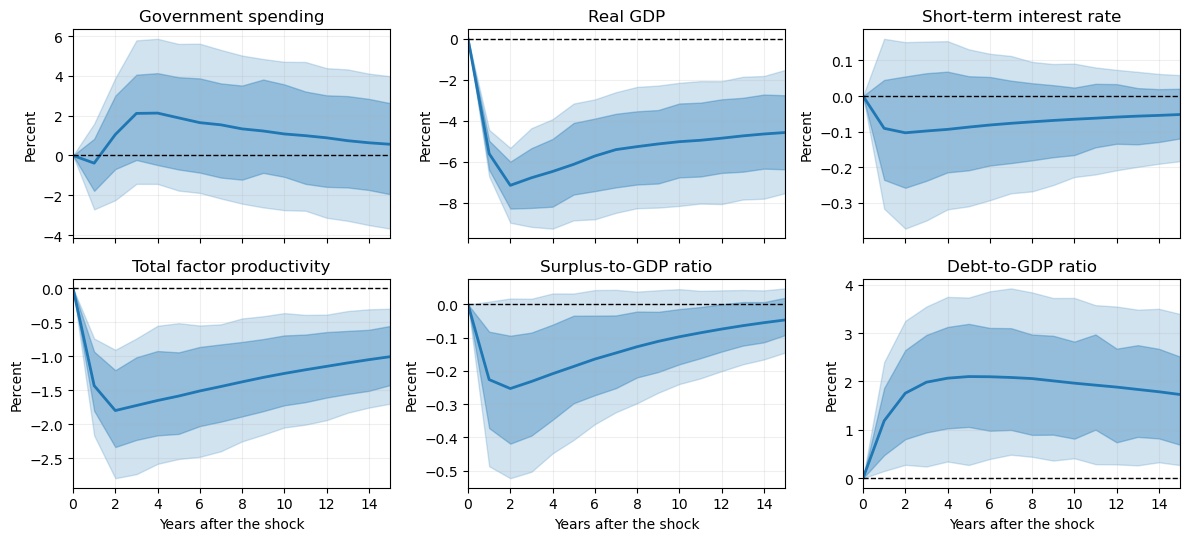

In [18]:
pretty = {
    "log_gov_pc": "Government spending",
    "log_rgdp_pc": "Real GDP",
    "tbill": "Short-term interest rate",
    "log_tfp": "Total factor productivity",
    "def_gdp": "Surplus-to-GDP ratio",
    "debt_gdp": "Debt-to-GDP ratio",
}

shock_var = "mil_delta"  # whatever you shock
resp_vars = [v for v in vars_endog if v != shock_var]   # exclude the first/shock var

def hdi_bounds(y, prob):
    arr = xr.DataArray(y, dims=("draw","horizon")).expand_dims(chain=[0])
    h = az.hdi(arr, hdi_prob=prob)
    if isinstance(h, xr.Dataset):
        h = next(iter(h.data_vars.values()))
    lo = h.sel(hdi="lower").values
    hi = h.sel(hdi="higher").values
    return lo, hi

h = np.arange(H + 1)
xmax = 15
xticks = np.arange(0, xmax + 1, 2)

n = len(resp_vars)   # 5
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6), sharex=True)
axes = np.atleast_1d(axes).ravel()

for ax, name in zip(axes, resp_vars):
    j = vars_endog.index(name)
    y = irfs_plot[:, :, j]  # (S,H+1)

    med = np.median(y, axis=0)
    lo90, hi90 = hdi_bounds(y, 0.90)
    lo68, hi68 = hdi_bounds(y, 0.68)

    ax.fill_between(h, lo90, hi90, alpha=0.20, color="C0")
    ax.fill_between(h, lo68, hi68, alpha=0.35, color="C0")
    ax.plot(h, med, linewidth=2)
    ax.axhline(0, linestyle="--", linewidth=1, color="black")
    ax.set_xlim(0, xmax)

    ax.set_title(pretty.get(name, name))
    ax.set_ylabel("Percent")
    ax.grid(alpha=0.2)
    ax.set_xticks(xticks)

# turn off unused axes
for ax in axes[len(vars_endog):]:
    ax.axis("off")

# x-label only on bottom row
for ax in axes[-ncols:]:
    ax.set_xlabel("Years after the shock")

#fig.suptitle("Impulse Responses to Defense Expenditure Shock", y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.savefig(Path.cwd().parent / "figures" / "europe_pooled_bvar.png")